In [202]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tqdm
from tqdm import trange

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### 

In [203]:
df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/new_bonsai_df_cleaned.csv')

df = bu.filter_by_group_size(df, 
                             group_col='subject_id', 
                             max_rows=10,
)

df = bu.add_session_column(df)

In [204]:
def calculate_session_proportion(df):
    """
    Calculate session proportion for each subject by dividing current session number 
    by total number of sessions for that subject.
    
    Args:
    df : pd.DataFrame
        DataFrame containing 'subject_id' and 'session' columns
        
    Returns
    pd.DataFrame
        Input DataFrame with new 'session_proportion' column added
    """
    # Get unique subjects
    subjects = df['subject_id'].unique()
    
    # For each subject
    for subject in subjects:
        # Get total sessions for this subject
        subject_df = df[df['subject_id'] == subject]
        total_sessions = len(subject_df)
        
        # Calculate proportion and assign to new column
        mask = df['subject_id'] == subject
        df.loc[mask, 'session_proportion'] = \
            df.loc[mask, 'new_session'] / total_sessions
        
        # Create classifications based on session proportion for each subject
        subject_proportions = df.loc[mask, 'session_proportion']
        df.loc[mask, 'session_proportion_class'] = pd.cut(
            subject_proportions,
            bins = [float('-inf'), 0.33, 0.66, float('inf')],
            labels = [0, 1, 2]
        )

    return df

df = calculate_session_proportion(df)

df


,subject_id,session_date,nwb_suffix,rig,user_name,experiment_description,task,notes,session_start_time,session_end_time,...,invalid_lick_ratio,double_dipping_rate_finished_trials,double_dipping_rate_finished_reward_trials,double_dipping_rate_finished_noreward_trials,lick_consistency_mean_finished_trials,lick_consistency_mean_finished_reward_trials,lick_consistency_mean_finished_noreward_trials,new_session,session_proportion,session_proportion_class
0,668463,2023-07-07,1,Tower-1,Lucas,NaN,Coupled Baiting,NaN,2023-07-07 14:52:24.298459-07:00,2023-07-07 16:14:04.346112,...,0.721908,0.092308,0.117647,0.070922,0.966332,0.964094,0.968220,1,0.50,1
1,668463,2023-07-10,0,Tower-1,Lucas,NaN,Coupled Baiting,NaN,2023-07-10 15:02:43.617225-07:00,2023-07-10 16:56:00.735798,...,0.759481,0.392617,0.450000,0.363636,0.844578,0.860236,0.836670,2,1.00,2
2,668551,2023-06-15,3,Tower-5,Lucas,NaN,Coupled Without Baiting,NaN,2023-06-15 14:31:02.214445-07:00,2023-06-15 15:21:43.186666,...,0.226983,0.368984,0.476562,0.138889,0.838369,0.757762,0.946067,1,0.50,1
3,668551,2023-06-16,1,Tower-5,Lucas,NaN,Coupled Without Baiting,NaN,2023-06-16 14:06:18.098724-07:00,2023-06-16 14:55:32.172148,...,0.325333,0.799308,0.784452,0.529412,0.777771,0.772814,0.811625,2,1.00,2
4,671087,2023-07-06,0,Tower-1,Travis,NaN,Coupled Baiting,NaN,2023-07-06 13:03:36.430257-07:00,2023-07-06 13:52:45.128836,...,0.416410,0.526132,0.488038,0.628205,0.825732,0.877053,0.688217,1,1.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,776293,2025-01-09,111047,447-1-A,Ella Hilton,NaN,Coupled Baiting,NaN,2025-01-09 11:10:47.896990-08:00,2025-01-09 12:25:51.578429,...,0.787960,0.039286,0.025316,0.056911,0.978224,0.985456,0.968993,2,1.00,2
2036,776296,2025-01-06,122357,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-06 12:23:57.056318-08:00,2025-01-06 13:29:03.887625,...,0.618026,0.080153,0.066667,0.099010,0.963531,0.973418,0.947772,1,0.25,0
2037,776296,2025-01-07,121657,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-07 12:16:57.371110-08:00,2025-01-07 13:32:01.428214,...,0.811455,0.037931,0.006803,0.069930,0.975390,0.994898,0.955336,2,0.50,1
2038,776296,2025-01-08,132251,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-08 13:22:51.765949-08:00,2025-01-08 14:38:01.948262,...,0.761496,0.020202,0.005650,0.041322,0.989081,0.999188,0.974380,3,0.75,2


In [205]:
df.columns.tolist()

['subject_id',
 'session_date',
 'nwb_suffix',
 'rig',
 'user_name',
 'experiment_description',
 'task',
 'notes',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_gocue_stop_median',
 'duration_gocue_stop_min',
 'duration_gocue_stop_max',
 'du

In [206]:
def clean_numeric_features(df, cols, nan_strategy='knn', target_col='session_proportion', min_samples = 2,  knn_neighbors=5, add_indicator=False):
    """
    Clean numeric features by imputing missing values using KNNImputer
    
    Args:
        df: pd.DataFrame
            Input DataFrame
        cols: list
            List of columns to clean
        nan_strategy: str
            Strategy for imputing missing values
        min_samples: int
            Minimum number of samples in each neighborhood for KNNImputer
        knn_neighbors: int
            Number of neighbors to use for KNNImputer
        add_indicator: bool
            If True, add indicator columns for missing values
            
    Returns:
        pd.DataFrame
            DataFrame with cleaned numeric features
    """

    # Create a copy of the dataframe
    df_clean = df.copy()

    # Remove target samples under threshold
    class_counts = df_clean[target_col].value_counts()
    valid_classes = class_counts[class_counts >= min_samples].index
    df_clean = df_clean[df_clean[target_col].isin(valid_classes).copy()]

    new_columns = []

    # Handle infinite values
    for col in cols:
        df_clean.loc[:, col] = df_clean[col].replace([np.inf, -np.inf], np.nan)

    if add_indicator:
        for col in cols:
            if df_clean[col].isna().any():
                indicator_col = f'{col}_is_missing'
                df_clean.loc[:, indicator_col] = df_clean[col].isna().astype(int)
                new_columns.append(indicator_col)

    # drop strat
    if nan_strategy == 'drop':
        df_clean = df_clean.dropna(subset=cols)
    
    # knn strat
    elif nan_strategy == 'knn':
        imputer = KNNImputer(n_neighbors=knn_neighbors)
        df_clean[cols] = imputer.fit_transform(df_clean[cols])

    # median strat
    elif nan_strategy == 'median' or nan_strategy == 'indicator':
        for col in cols:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)

    # Handle extreme values after imputation
    for col in cols:
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
        
    return df_clean, new_columns

In [207]:
feature_cols = [
                'reward_rate', 
                'finished_rate', 
                'double_dipping_rate_finished_trials',
                'foraging_eff',
                'early_lick_rate', 
                'invalid_lick_ratio',
                'lick_consistency_mean_finished_trials',
                'reaction_time_mean'
                ]

cat_cols = ['curriculum_name']

target_col = 'session_proportion_class'

In [208]:
clean_df, _ = clean_numeric_features(df, 
                                  cols = feature_cols, 
                                  nan_strategy='drop',
                                  add_indicator=True
                                  )

feature_cols = [
                'reward_rate', 
                'finished_rate', 
                'double_dipping_rate_finished_trials',
                'foraging_eff',
                'early_lick_rate', 
                'invalid_lick_ratio',
                'lick_consistency_mean_finished_trials',
                'reaction_time_mean',
                'reward_rate_is_missing',
                'finished_rate_is_missing',
                'foraging_eff_is_missing',
                'lick_consistency_mean_finished_trials_is_missing',
                'reaction_time_mean_is_missing'
                ]

clean_df

,subject_id,session_date,nwb_suffix,rig,user_name,experiment_description,task,notes,session_start_time,session_end_time,...,lick_consistency_mean_finished_reward_trials,lick_consistency_mean_finished_noreward_trials,new_session,session_proportion,session_proportion_class,reward_rate_is_missing,finished_rate_is_missing,foraging_eff_is_missing,lick_consistency_mean_finished_trials_is_missing,reaction_time_mean_is_missing
0,668463,2023-07-07,1,Tower-1,Lucas,NaN,Coupled Baiting,NaN,2023-07-07 14:52:24.298459-07:00,2023-07-07 16:14:04.346112,...,0.964094,0.968220,1,0.50,1,0,0,0,0,0
1,668463,2023-07-10,0,Tower-1,Lucas,NaN,Coupled Baiting,NaN,2023-07-10 15:02:43.617225-07:00,2023-07-10 16:56:00.735798,...,0.860236,0.836670,2,1.00,2,0,0,0,0,0
2,668551,2023-06-15,3,Tower-5,Lucas,NaN,Coupled Without Baiting,NaN,2023-06-15 14:31:02.214445-07:00,2023-06-15 15:21:43.186666,...,0.757762,0.946067,1,0.50,1,0,0,0,0,0
3,668551,2023-06-16,1,Tower-5,Lucas,NaN,Coupled Without Baiting,NaN,2023-06-16 14:06:18.098724-07:00,2023-06-16 14:55:32.172148,...,0.772814,0.811625,2,1.00,2,0,0,0,0,0
4,671087,2023-07-06,0,Tower-1,Travis,NaN,Coupled Baiting,NaN,2023-07-06 13:03:36.430257-07:00,2023-07-06 13:52:45.128836,...,0.877053,0.688217,1,1.00,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,776293,2025-01-09,111047,447-1-A,Ella Hilton,NaN,Coupled Baiting,NaN,2025-01-09 11:10:47.896990-08:00,2025-01-09 12:25:51.578429,...,0.985456,0.968993,2,1.00,2,0,0,0,0,0
2036,776296,2025-01-06,122357,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-06 12:23:57.056318-08:00,2025-01-06 13:29:03.887625,...,0.973418,0.947772,1,0.25,0,0,0,0,0,0
2037,776296,2025-01-07,121657,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-07 12:16:57.371110-08:00,2025-01-07 13:32:01.428214,...,0.994898,0.955336,2,0.50,1,0,0,0,0,0
2038,776296,2025-01-08,132251,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-08 13:22:51.765949-08:00,2025-01-08 14:38:01.948262,...,0.999188,0.974380,3,0.75,2,0,0,0,0,0


In [209]:
def preprocess_data(df, feature_cols, cat_cols, target_col, test_size = 0.2, random_state = 42):
    """
    Preprocess data for machine basic neural network classification model

    Args: 
    df : pd.DataFrame
        Input df with features and targets
    feature_cols : list
        Names of numerical features
    cat_cols : list
        Names of categorical columns to encode
    target_col : str
        Name of target column to classify in output layer
    test_size: float
        Proportion of data to use for testing

    Returns:
    dict:
        X_train, X_test : preprocessed feature 
        y_train, y_test : encoded target variables
        encoders : dict of fitted LabelEncoders for each categorical feature
        scaler : fitted StandardScaler for numerical features
    """

    df_copy = df.copy()

    # Initialize encoders and scaler
    encoders = {}
    scaler = StandardScaler()
    
    # Categorical column handling 
    encoded_cats = []
    for col in cat_cols:
        if col != target_col:
            encoders[col] = LabelEncoder()
            df_copy[f'{col}_encoded'] = encoders[col].fit_transform(df_copy[col])
            encoded_cats.append(f'{col}_encoded')
    
    # Combine categorical and numerical features
    final_features = feature_cols + encoded_cats
    
    # Scale numerical features
    X = df_copy[final_features].copy()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=final_features)

    # Encode target variable
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(df_copy[target_col])
    encoders['target'] = target_encoder

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size = test_size,
        random_state = random_state,
        stratify = y
    )

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train, 
        'y_test': y_test,
        'encoders': encoders,
        'scaler': scaler
    }

In [210]:


processed_df = preprocess_data(
    df = clean_df,
    feature_cols = feature_cols,
    cat_cols = cat_cols,
    target_col = target_col
)

print(processed_df['X_train'].shape, processed_df['y_train'].shape)


(783, 14) (783,)


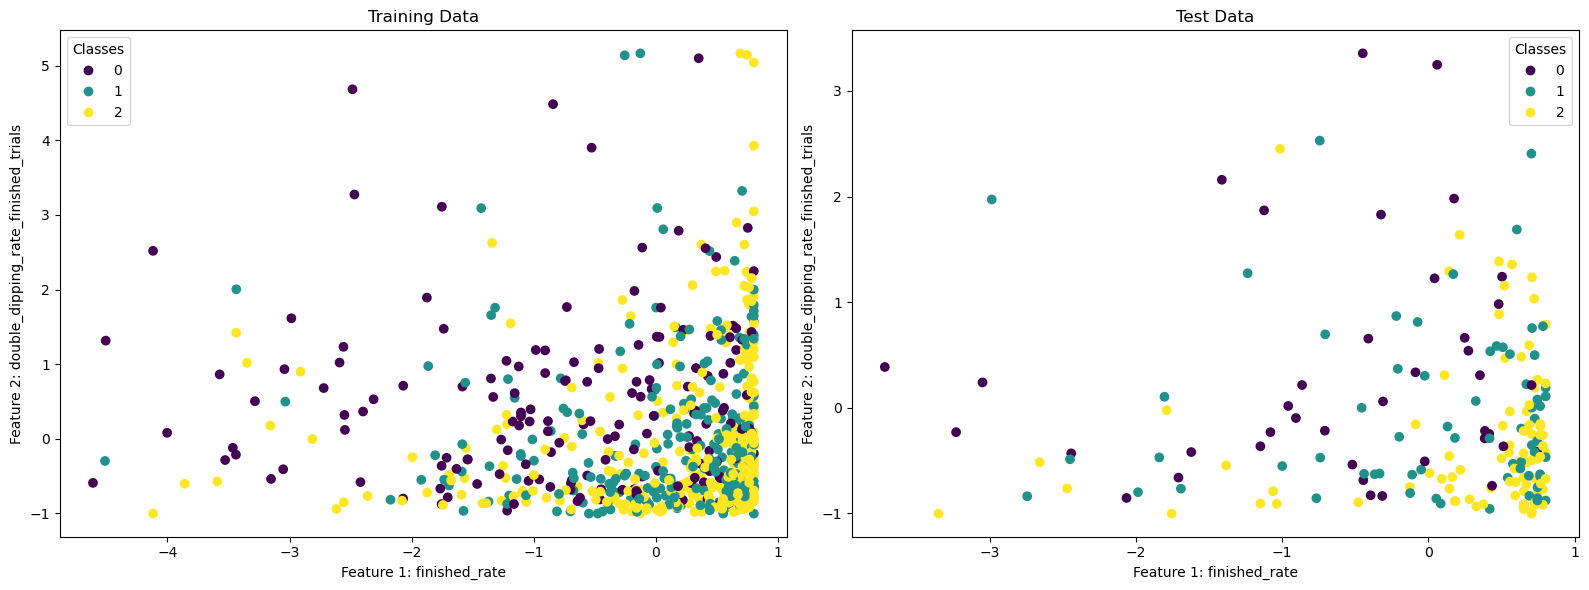

In [211]:
# Visualize dataset before training

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get first two features for visualization
X_train_2d = processed_df['X_train'].iloc[:, :3]
X_test_2d = processed_df['X_test'].iloc[:, :3]

# Training data scatter plot
scatter1 = ax1.scatter(X_train_2d.iloc[:, 1], X_train_2d.iloc[:, 2], 
                      c=processed_df['y_train'], cmap='viridis')
ax1.set_title('Training Data')
ax1.set_xlabel(f'Feature 1: {processed_df["X_train"].columns[1]}')
ax1.set_ylabel(f'Feature 2: {processed_df["X_train"].columns[2]}')
ax1.legend(*scatter1.legend_elements(), title="Classes")

# Test data scatter plot  
scatter2 = ax2.scatter(X_test_2d.iloc[:, 1], X_test_2d.iloc[:, 2],
                      c=processed_df['y_test'], cmap='viridis')
ax2.set_title('Test Data')
ax2.set_xlabel(f'Feature 1: {processed_df["X_test"].columns[1]}')
ax2.set_ylabel(f'Feature 2: {processed_df["X_test"].columns[2]}')
ax2.legend(*scatter2.legend_elements(), title="Classes")

plt.tight_layout()


##### Define model

In [212]:
class BasicForagingClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim): # initialize input, hidden, and output dimensions

        super(BasicForagingClassifier, self).__init__() # initialize all functions from class

        self.layer1 = nn.Linear(input_dim, hidden_dim) # first layer
        self.layer2 = nn.Linear(hidden_dim, output_dim) # second layer

    def forward(self, x): # forward propagation

        x = torch.relu(self.layer1(x)) # define activation function for layer 1
        x = self.layer2(x) # define layer 2
        
        return x

In [213]:
# Define hyperparameters

model = BasicForagingClassifier(input_dim = 14, hidden_dim = 500, output_dim=3)

learning_rate = 0.001
epochs = 10000

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [214]:
# Follow model performance per epoch

train_loss_list = []


##### Train model

In [215]:
# Convert DataFrame/Series to numpy arrays before converting to torch tensors
X_train = torch.from_numpy(processed_df['X_train'].to_numpy()).float()
y_train = torch.from_numpy(processed_df['y_train']).long()

y_train = F.one_hot(y_train, num_classes=3).float()  # Convert to float for MSE loss

for epoch in tqdm.trange(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_func(outputs, y_train)

    loss.backward()
    optimizer.step()
    train_loss_list.append(loss.item())

100%|██████████| 10000/10000 [00:05<00:00, 1951.60it/s]


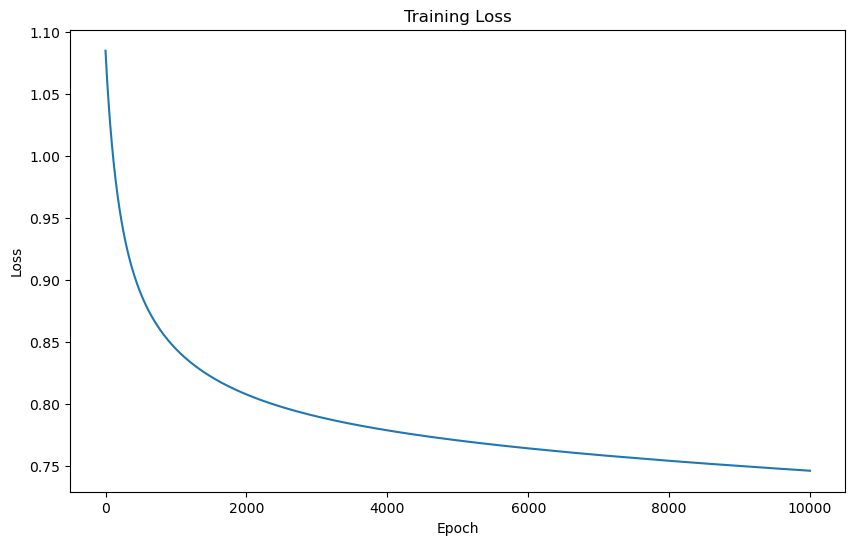

In [216]:
# Visualize and evaluate model performance

plt.figure(figsize=(10, 6))

plt.plot(range(epochs), train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [217]:
# Convert test data to tensors
X_test = torch.from_numpy(processed_df['X_test'].to_numpy()).float()
y_test = torch.from_numpy(processed_df['y_test']).long()

# Get model predictions
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    predicted_classes = torch.argmax(test_outputs, dim=1)
    
# Calculate accuracy
correct = (predicted_classes == y_test).sum().item()
total = y_test.size(0)
accuracy = correct / total

print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.5816
